In [2]:
import ipyparallel as ipp

cluster = ipp.Cluster(engines="mpi", n=6).start_and_connect_sync()
%autopx

Starting 6 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/6 [00:00<?, ?engine/s]

%autopx enabled


In [3]:
from mpi4py import MPI

mpi_comm = MPI.COMM_WORLD
mpi_size = mpi_comm.Get_size()
mpi_rank = mpi_comm.Get_rank()

In [4]:
%%capture
from pace.util import CubedSphereCommunicator, CubedSpherePartitioner, TilePartitioner

layout = (1, 1)
partitioner = CubedSpherePartitioner(TilePartitioner(layout))
communicator = CubedSphereCommunicator(mpi_comm, partitioner)

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

In [5]:
from pace.util import QuantityFactory, SubtileGridSizer

backend = "numpy"

sizer = SubtileGridSizer.from_tile_params(
    nx_tile=12,
    ny_tile=12,
    nz=79,
    n_halo=3,
    extra_dim_lengths={},
    layout=layout,
    tile_partitioner=partitioner.tile,
    tile_rank=communicator.tile.rank,
)

quantity_factory = QuantityFactory.from_backend(sizer=sizer, backend=backend)

In [13]:
from datetime import datetime

restart_path = "/home/ajdas/pace/restart_data/v1.0"
restart_time = datetime.strptime("2016-08-11 00:00:00", "%Y-%m-%d %H:%M:%S")
fortran_data = True

serial_path = "/home/ajdas/pace/test_data/8.1.1/c12_6ranks_baroclinic_dycore_microphysics/driver/"
serialized_grid = True

In [14]:
%%capture
from pace.driver.initialization import RestartConfig

restart_config = RestartConfig(path=restart_path, start_time=restart_time, fortran_data=fortran_data)
fortran_state = restart_config.get_driver_state(quantity_factory, communicator)

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

In [15]:
import sys
sys.path.append("/usr/local/serialbox/python")
from pace.driver.initialization import SerialboxConfig

serialbox_config = SerialboxConfig(path=serial_path, serialized_grid=serialized_grid)
serialbox_state = serialbox_config.get_driver_state(quantity_factory, communicator)

In [16]:
if mpi_rank == 0:
    print("Fortran dycore:", fortran_state.__dict__["dycore_state"].__dict__.keys())
    print("Serialbox dycore:", serialbox_state.__dict__["dycore_state"].__dict__.keys())
    print()
    print("Fortran physics:", fortran_state.__dict__["physics_state"].__dict__.keys())
    print("Serialbox physics:", serialbox_state.__dict__["physics_state"].__dict__.keys())
    print()
    print("Fortran tendency:", fortran_state.__dict__["tendency_state"].__dict__.keys())
    print("Serialbox tendency:", serialbox_state.__dict__["tendency_state"].__dict__.keys())
    print()
    print("Fortran grid data:", fortran_state.__dict__["grid_data"].__dict__.keys())
    print("Serialbox grid_data:", serialbox_state.__dict__["grid_data"].__dict__.keys())
    print()
    print("Fortran damping_coefficients:", fortran_state.__dict__["damping_coefficients"].__dict__.keys())
    print("Serialbox damping_coefficients:", serialbox_state.__dict__["damping_coefficients"].__dict__.keys())
    print()
    print("Fortran driver grid data:", fortran_state.__dict__["driver_grid_data"].__dict__.keys())
    print("Serialbox driver grid_data:", serialbox_state.__dict__["driver_grid_data"].__dict__.keys())
    print()

[stdout:0] Fortran dycore: dict_keys(['u', 'v', 'w', 'ua', 'va', 'uc', 'vc', 'delp', 'delz', 'ps', 'pe', 'pt', 'peln', 'pk', 'pkz', 'qvapor', 'qliquid', 'qice', 'qrain', 'qsnow', 'qgraupel', 'qo3mr', 'qsgs_tke', 'qcld', 'q_con', 'omga', 'mfxd', 'mfyd', 'cxd', 'cyd', 'diss_estd', 'phis', 'do_adiabatic_init', 'bdt', 'mdt'])
Serialbox dycore: dict_keys(['u', 'v', 'w', 'ua', 'va', 'uc', 'vc', 'delp', 'delz', 'ps', 'pe', 'pt', 'peln', 'pk', 'pkz', 'qvapor', 'qliquid', 'qice', 'qrain', 'qsnow', 'qgraupel', 'qo3mr', 'qsgs_tke', 'qcld', 'q_con', 'omga', 'mfxd', 'mfyd', 'cxd', 'cyd', 'diss_estd', 'phis', 'do_adiabatic_init', 'bdt', 'mdt'])

Fortran physics: dict_keys(['qvapor', 'qliquid', 'qice', 'qrain', 'qsnow', 'qgraupel', 'qo3mr', 'qsgs_tke', 'qcld', 'pt', 'delp', 'delz', 'ua', 'va', 'w', 'omga', 'physics_updated_specific_humidity', 'physics_updated_qliquid', 'physics_updated_qice', 'physics_updated_qrain', 'physics_updated_qsnow', 'physics_updated_qgraupel', 'physics_updated_cloud_fraction

# Compare fortran state and serialbox state
## DYCORE

In [17]:
import numpy as np

fortran_dycore = fortran_state.__dict__["dycore_state"]
serialbox_dycore = serialbox_state.__dict__["dycore_state"]
fortran_variable_list = sorted(list(fortran_dycore.__dict__.keys()))
serialbox_variable_list = sorted(list(serialbox_dycore.__dict__.keys()))

if mpi_rank == 0:
    print("Fortran")

fortran_vars = {}
for var in fortran_variable_list:
    try:
        fortran_vars[var] = communicator.gather(fortran_dycore.__dict__[var])
    except AttributeError:
        if mpi_rank == 0:
            print("Cannot gather: ", var)
            print("     Value: ", fortran_dycore.__dict__[var])


if mpi_rank == 0:
    print("Serialbox")
serialbox_vars = {}
for var in serialbox_variable_list:
    try:
        serialbox_vars[var] = communicator.gather(serialbox_dycore.__dict__[var])
    except AttributeError:
        if mpi_rank == 0:
            print("Cannot gather: ", var)
            print("     Value: ", serialbox_dycore.__dict__[var])


[stdout:0] Fortran
Cannot gather:  bdt
     Value:  0.0
Cannot gather:  do_adiabatic_init
     Value:  False
Cannot gather:  mdt
     Value:  0.0
Serialbox
Cannot gather:  bdt
     Value:  0.0
Cannot gather:  do_adiabatic_init
     Value:  False
Cannot gather:  mdt
     Value:  0.0


In [18]:
from pace.util import Quantity

fortran_lon = Quantity(data=np.zeros((19, 19)), dims=("x_interface", "y_interface"), units="degrees", origin=(3, 3), extent=(13, 13), gt4py_backend=backend)
fortran_lon.data[:] = fortran_state.__dict__["grid_data"].lon * 180/np.pi
fortran_lat = Quantity(data=np.zeros((19, 19)), dims=("x_interface", "y_interface"), units="degrees", origin=(3, 3), extent=(13, 13), gt4py_backend=backend)
fortran_lat.data[:] = fortran_state.__dict__["grid_data"].lat * 180/np.pi

serialbox_lon = Quantity(data=np.zeros((19, 19)), dims=("x_interface", "y_interface"), units="degrees", origin=(3, 3), extent=(13, 13), gt4py_backend=backend)
serialbox_lon.data[:] = serialbox_state.__dict__["grid_data"].lon * 180/np.pi
serialbox_lat = Quantity(data=np.zeros((19, 19)), dims=("x_interface", "y_interface"), units="degrees", origin=(3, 3), extent=(13, 13), gt4py_backend=backend)
serialbox_lat.data[:] = serialbox_state.__dict__["grid_data"].lat * 180/np.pi



In [19]:
flon = communicator.gather(fortran_lon)
flat = communicator.gather(fortran_lat)
slon = communicator.gather(serialbox_lon)
slat = communicator.gather(serialbox_lat)

In [20]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from fv3viz import pcolormesh_cube
from matplotlib.gridspec import GridSpec

sys.path.append("/home/ajdas/pace/examples/notebooks/")
import functions as funcs


%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

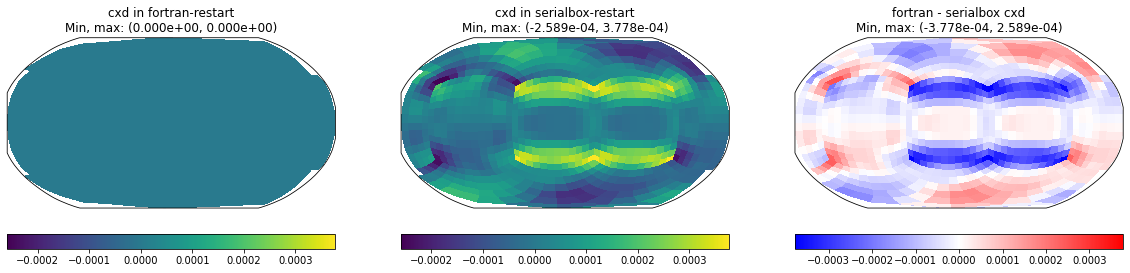

%px:   0%|          | 0/6 [00:00<?, ?tasks/s]

[output:0]

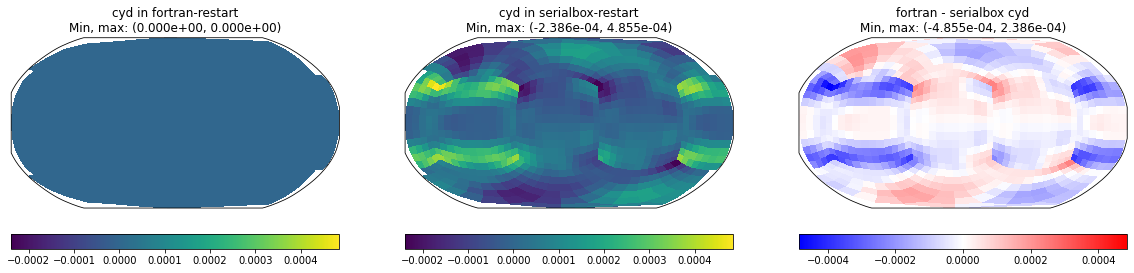

[output:0]

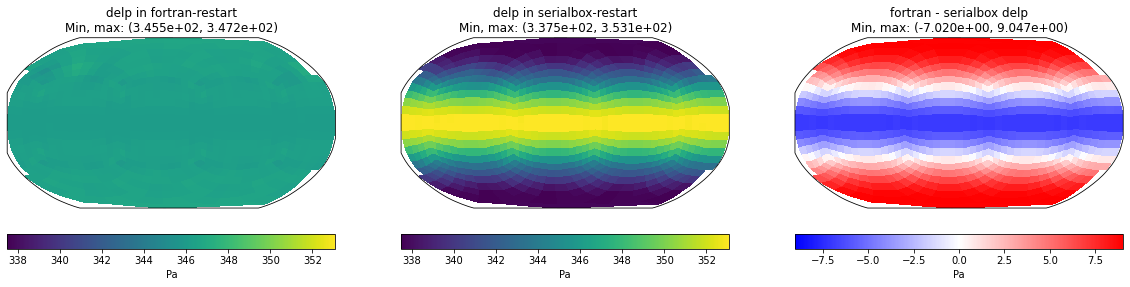

[output:0]

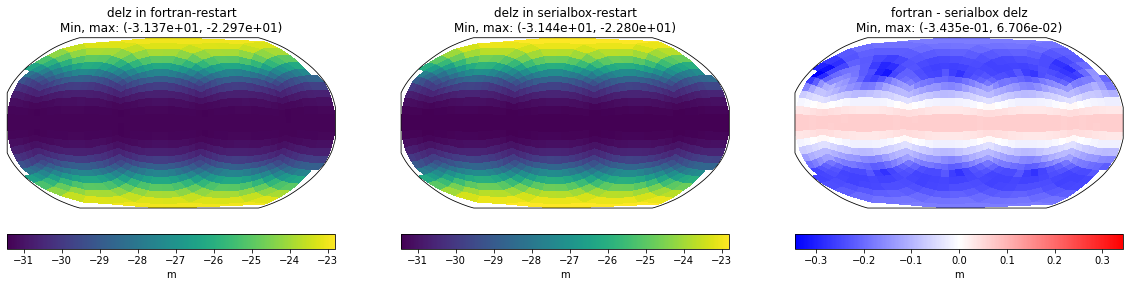

[output:0]

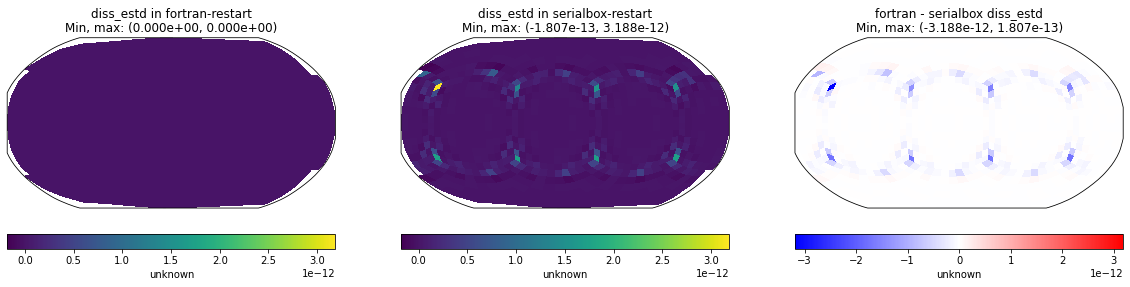

[output:0]

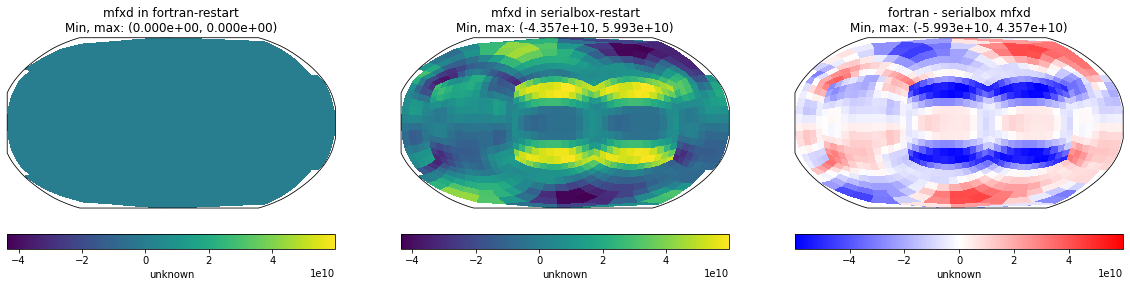

[output:0]

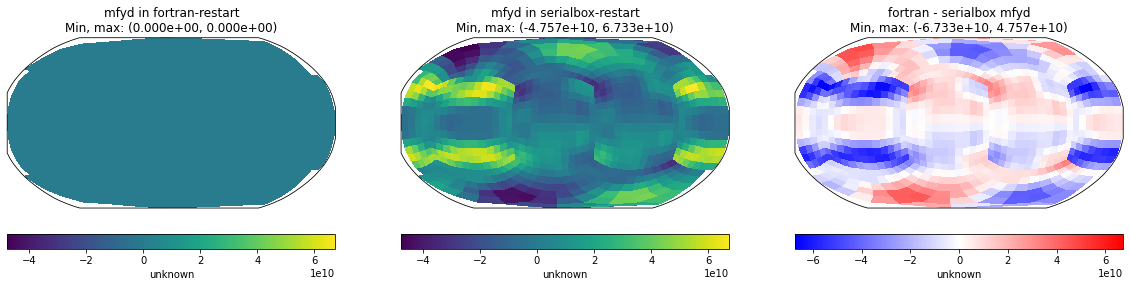

[output:0]

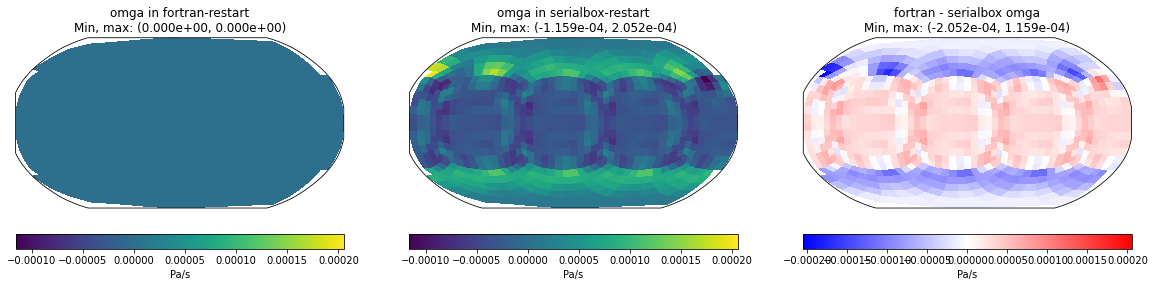

[output:0]

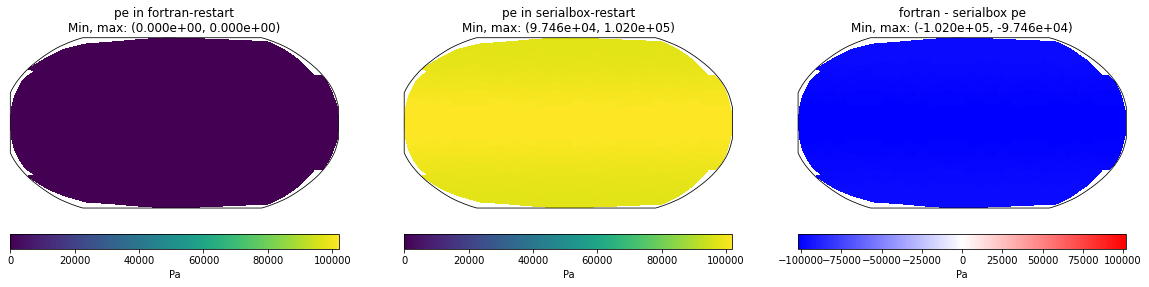

[output:0]

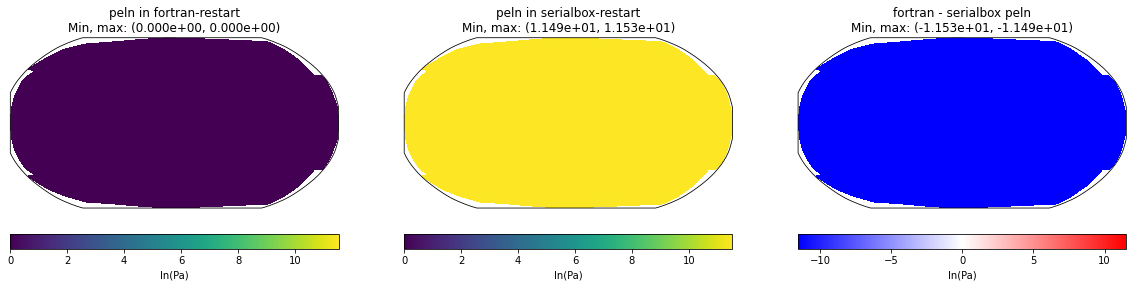

[output:0]

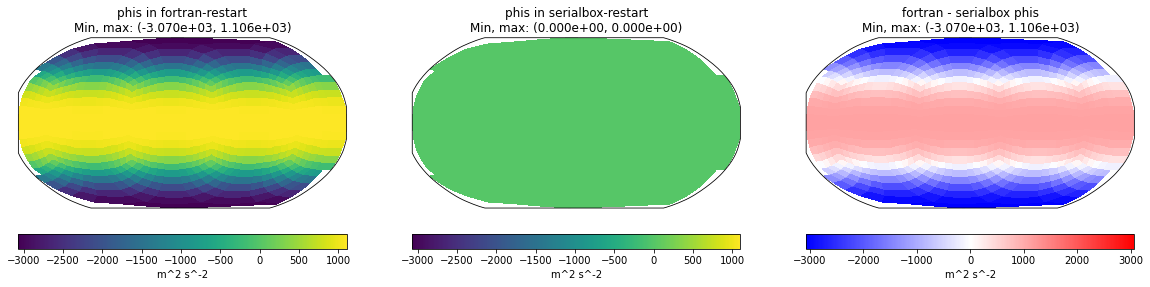

[output:0]

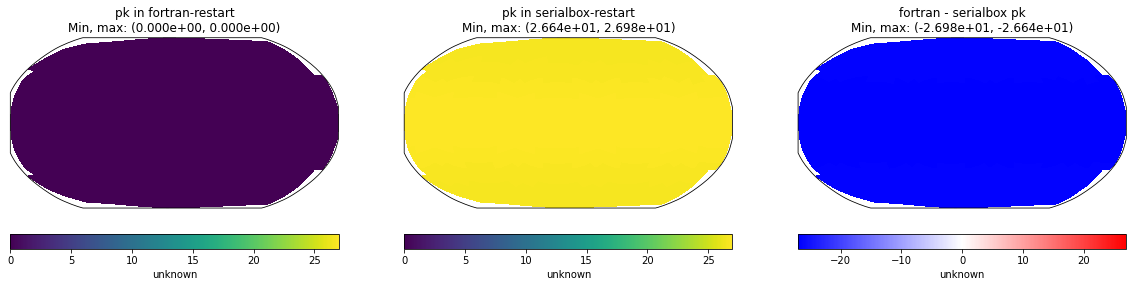

[output:0]

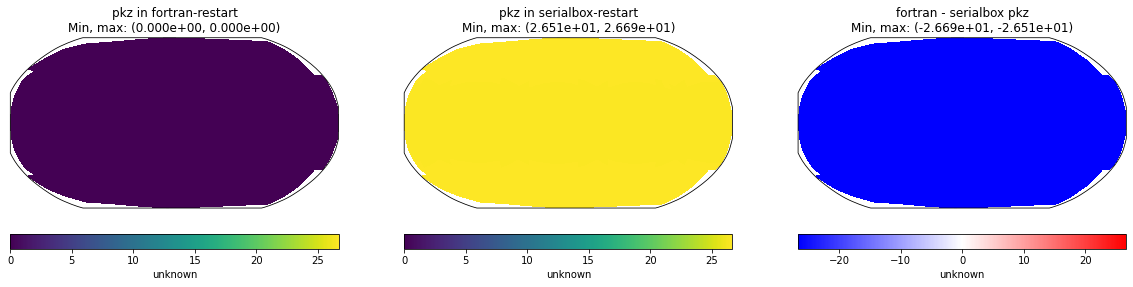

[output:0]

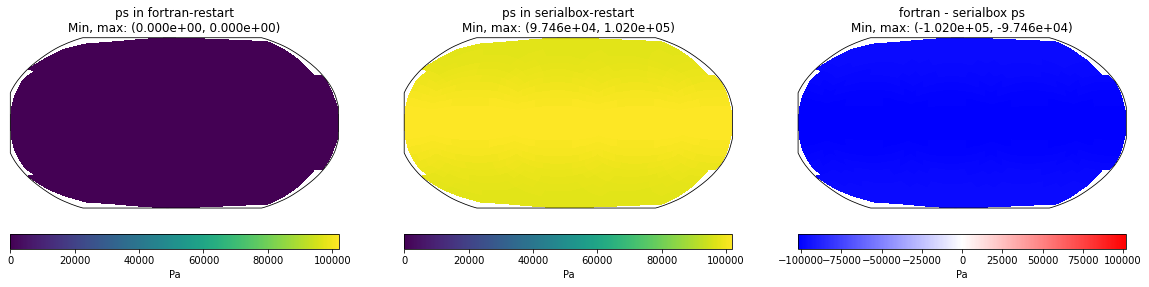

[output:0]

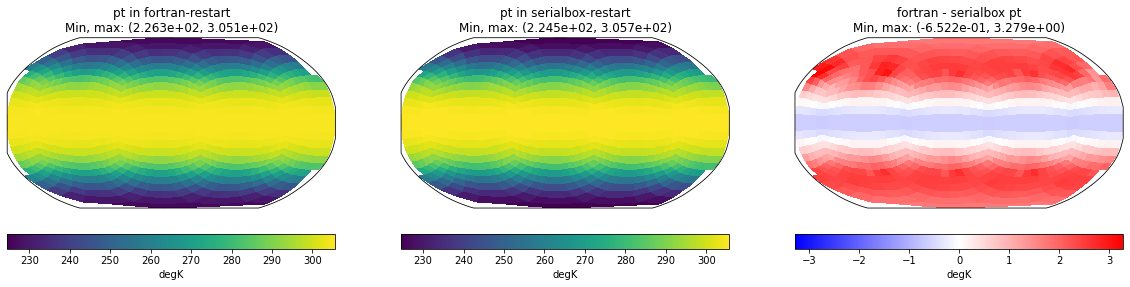

[output:0]

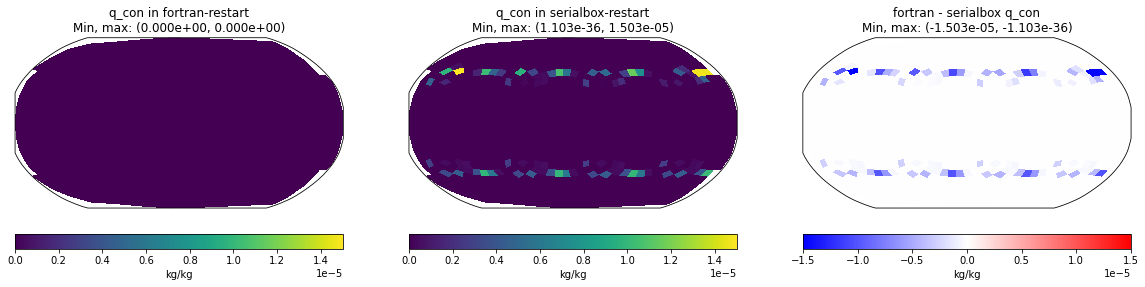

[output:0]

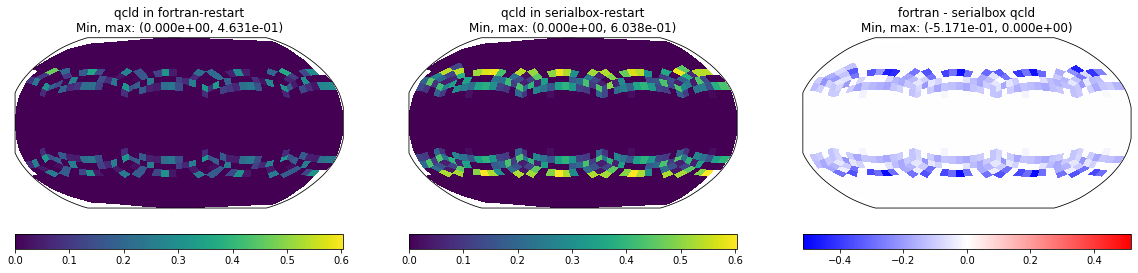

[output:0]

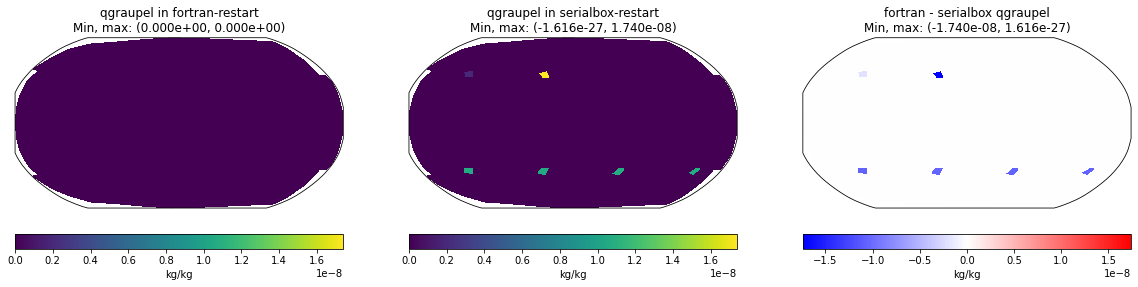

[output:0]

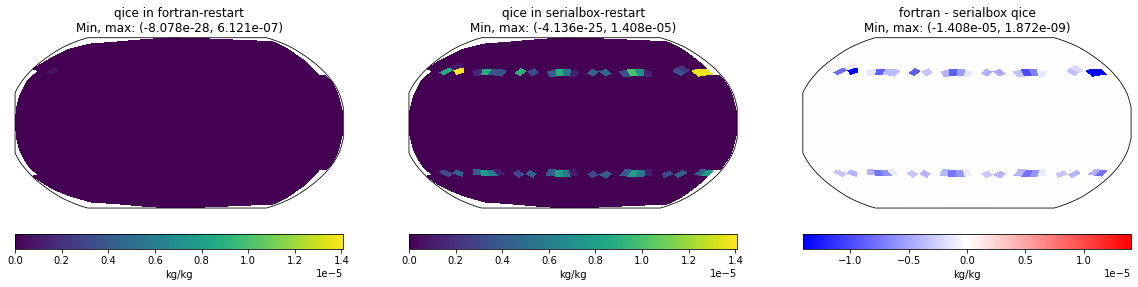

[output:0]

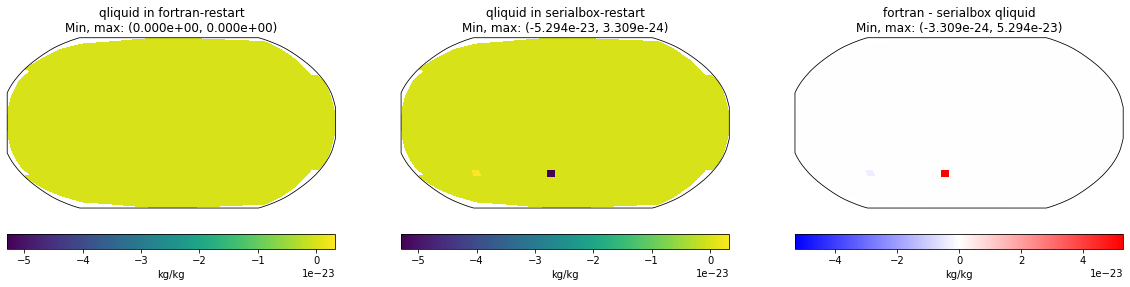

[output:0]

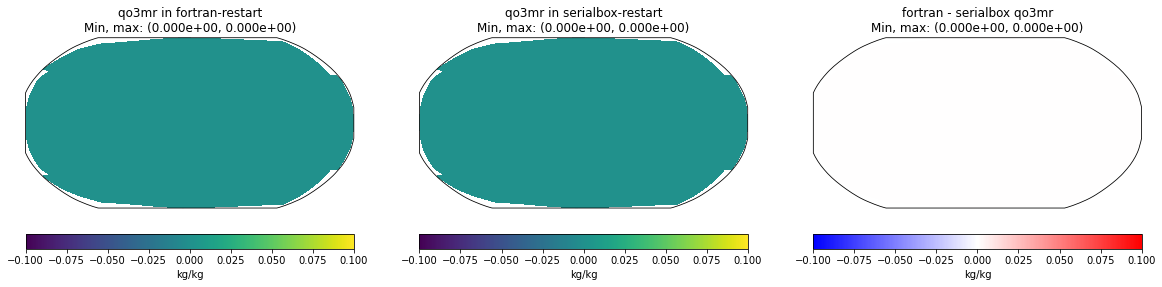

[output:0]

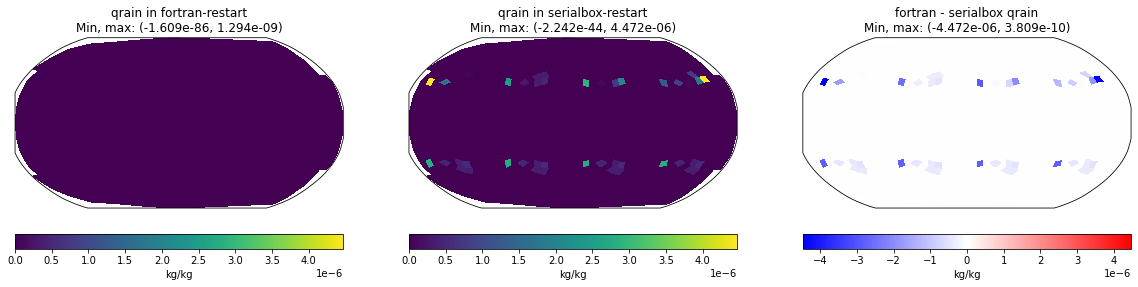

[output:0]

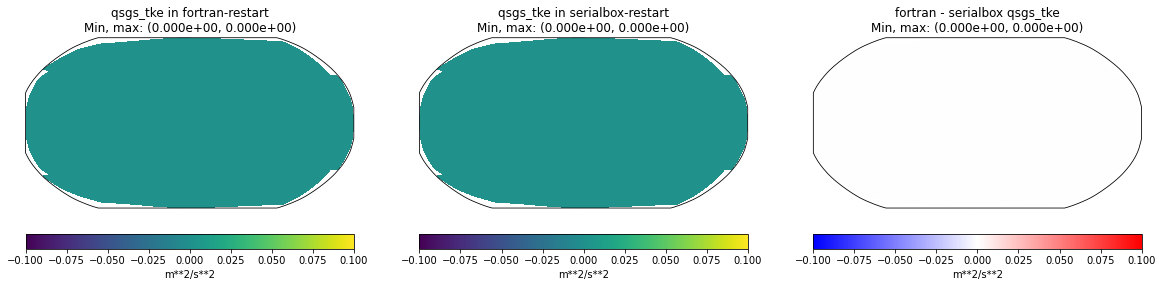

[output:0]

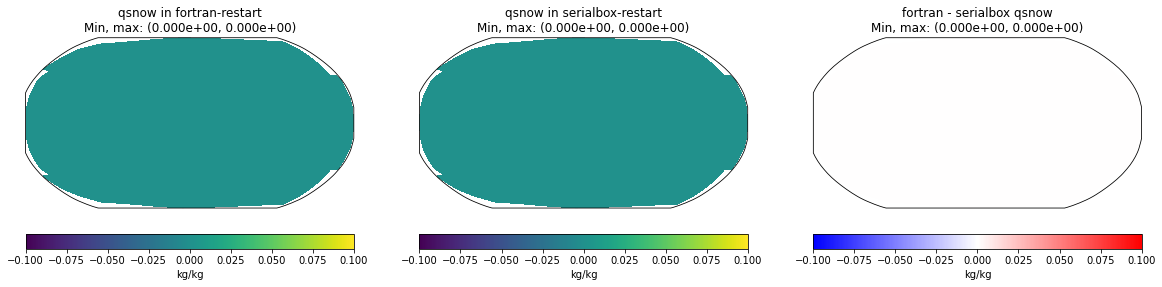

[output:0]

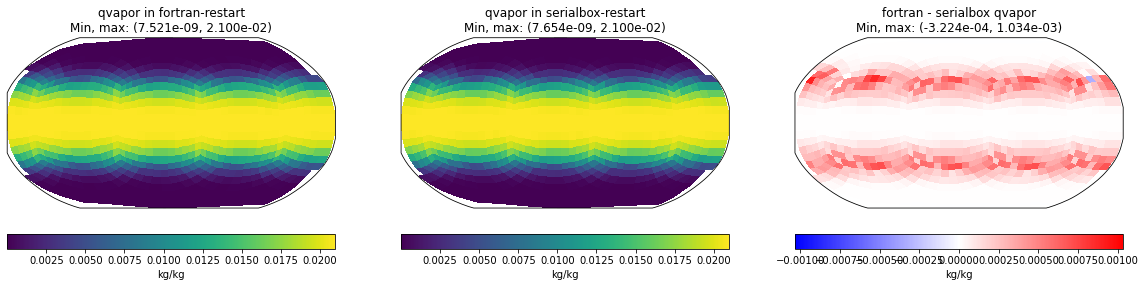

[output:0]

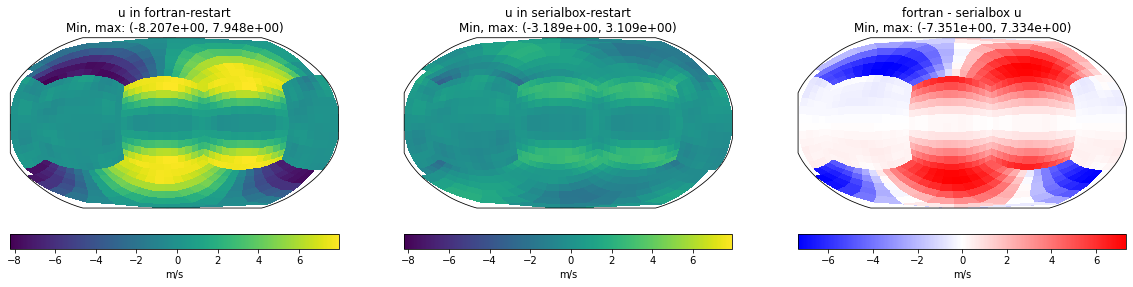

[output:0]

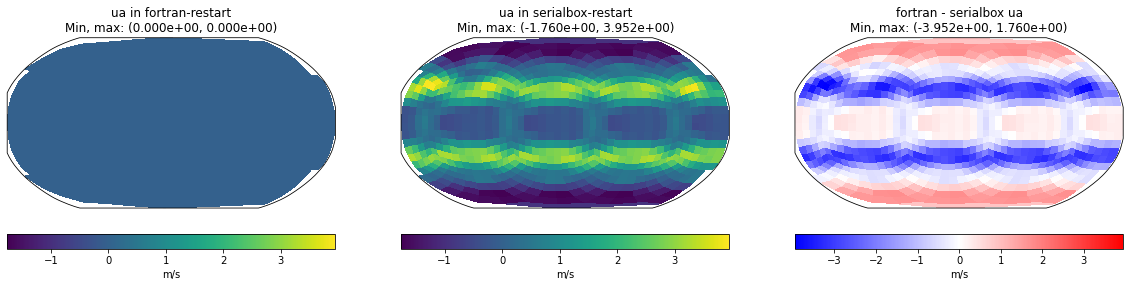

[output:0]

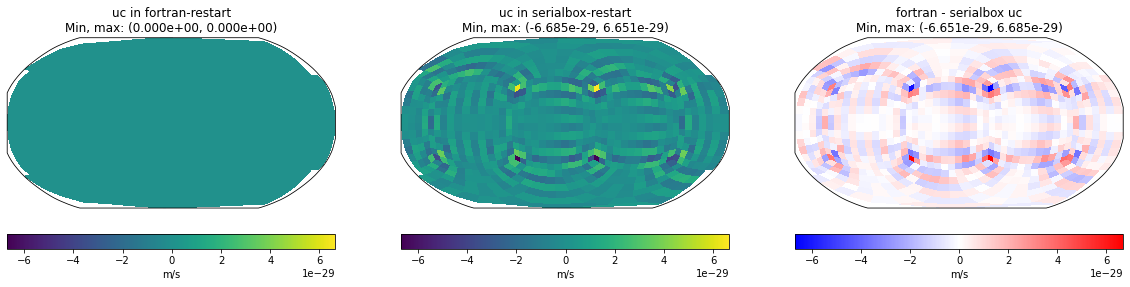

[output:0]

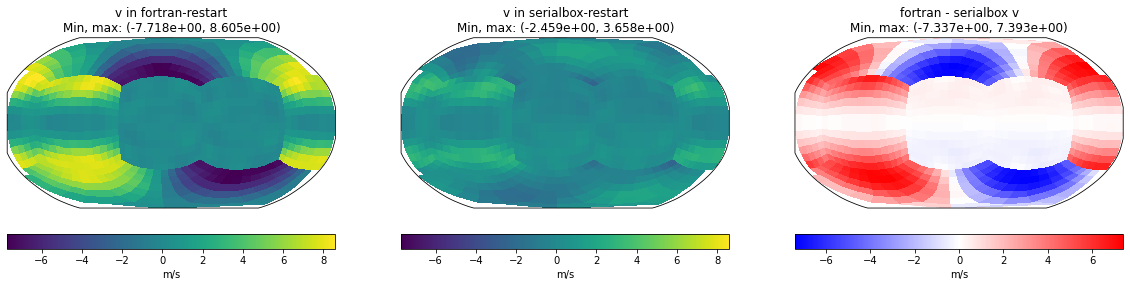

[output:0]

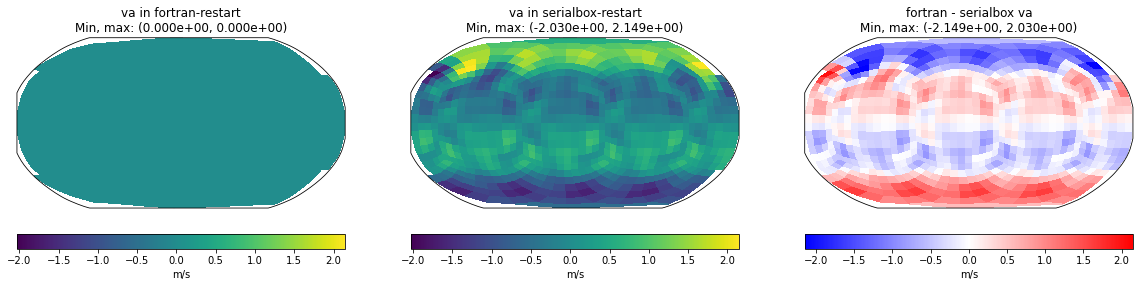

[output:0]

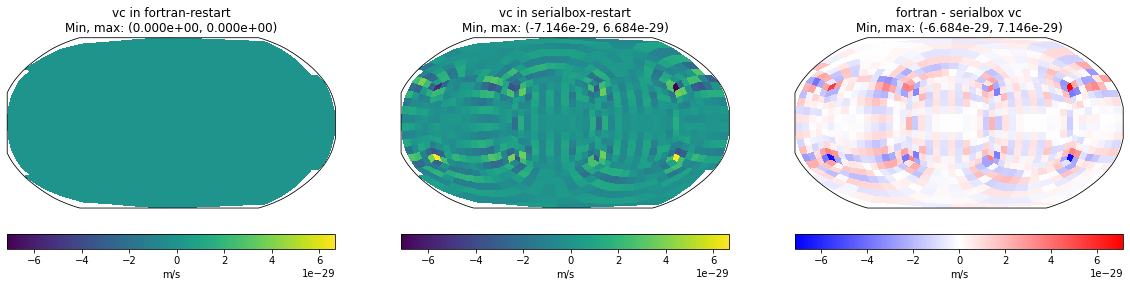

[output:0]

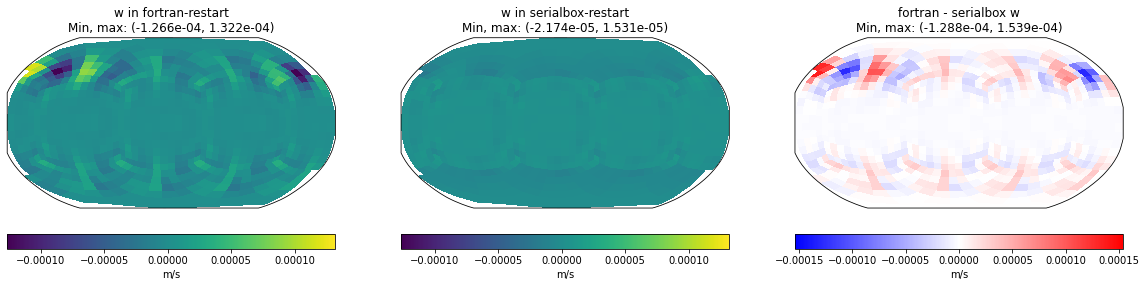

In [44]:
savedir = '/home/ajdas/pace/restart_data/figures_comparison_fortran_serialbox/'

for var in fortran_vars.keys():
    if var in serialbox_vars.keys():
    #if var == "qo3mr":
        #print(var)

        if mpi_rank == 0:
            fvar_index = fortran_variable_list.index(var)
            svar_index = serialbox_variable_list.index(var)

            tmp = fortran_vars[var].data
            if len(tmp.shape) == 4:
                ffield = funcs.unstagger_coordinate(fortran_vars[var].data[:, :, :, -1])
                sfield = funcs.unstagger_coordinate(serialbox_vars[var].data[:, :, :, -1])
            elif len(tmp.shape) == 3:
                ffield = funcs.unstagger_coordinate(fortran_vars[var].data[:, :, :])
                sfield = funcs.unstagger_coordinate(serialbox_vars[var].data[:, :, :])
            dfield = ffield - sfield


            minvals = min(np.nanmin(ffield), np.nanmin(sfield))
            maxvals = max(np.nanmax(ffield), np.nanmax(sfield))
            dextrema = max(np.abs(np.nanmin(dfield)), np.abs(np.nanmax(dfield)))
            if minvals == maxvals:
                minvals -= .1
                maxvals += .1
                dextrema += .1

    
            fig = plt.figure(figsize = (20, 4))
            fig.patch.set_facecolor('white')
            gs = GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,.08])
            fvar = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
            svar = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
            dvar = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson())

            cax_f = fig.add_subplot(gs[1, 0])
            cax_s = fig.add_subplot(gs[1, 1])
            cax_d = fig.add_subplot(gs[1, 2])

            f1 = pcolormesh_cube(flat.data, flon.data, ffield, ax=fvar, vmin=minvals, vmax=maxvals)
            f2 = pcolormesh_cube(flat.data, flon.data, sfield, ax=svar, vmin=minvals, vmax=maxvals)
            f3 = pcolormesh_cube(flat.data, flon.data, dfield, ax=dvar, vmin=-dextrema, vmax=dextrema, cmap="bwr")

            plt.colorbar(f1, cax=cax_f, orientation="horizontal", label=fortran_vars[var].units)
            plt.colorbar(f2, cax=cax_s, orientation="horizontal", label=fortran_vars[var].units)
            plt.colorbar(f3, cax=cax_d, orientation="horizontal", label=fortran_vars[var].units)

            fvar.set_title("%s in fortran-restart\nMin, max: (%.3e, %.3e)" % (var, ffield.min(), ffield.max()))
            svar.set_title("%s in serialbox-restart\nMin, max: (%.3e, %.3e)" % (var, sfield.min(), sfield.max()))
            dvar.set_title("fortran - serialbox % s\nMin, max: (%.3e, %.3e)" % (var, dfield.min(), dfield.max()))

            plt.savefig(savedir + "FS_dycoreState_v0_%s.png" % var, dpi=200, bbox_inches='tight')

            plt.show()

In [56]:
from netCDF4 import Dataset

restart_path = "/home/ajdas/pace/restart_data/v1.0"
serial_path = "/home/ajdas/pace/test_data/8.1.1/c12_6ranks_baroclinic_dycore_microphysics/driver/"

ser_data = Dataset(serial_path + "Driver-Out.nc", 'r')
pt_s = np.array(ser_data["pt"][0])
ser_data.close()

pt_f = []
for tile in range(1, 7, 1):
    for_data = Dataset(restart_path + "/fv_core.res.tile%s.nc" %tile, "r")
    pt_f.append(np.array(for_data["T"][0]))
    for_data.close()

pt_f = np.stack(pt_f)

if mpi_rank == 0:
    print(delp_s.shape, delp_f.shape)

[stdout:0] (6, 12, 12, 63) (6, 12, 12, 79)


Out[3:54]: <matplotlib.collections.QuadMesh at 0x7f8b550eac40>

Out[1:54]: <matplotlib.collections.QuadMesh at 0x7fba3c52ae20>

Out[4:54]: <matplotlib.collections.QuadMesh at 0x7ff360ea8400>

Out[5:54]: <matplotlib.collections.QuadMesh at 0x7fa2077ec7c0>

Out[2:54]: <matplotlib.collections.QuadMesh at 0x7fcc8626b1c0>

Out[0:54]: <matplotlib.collections.QuadMesh at 0x7fea8da1b4f0>

[output:1]

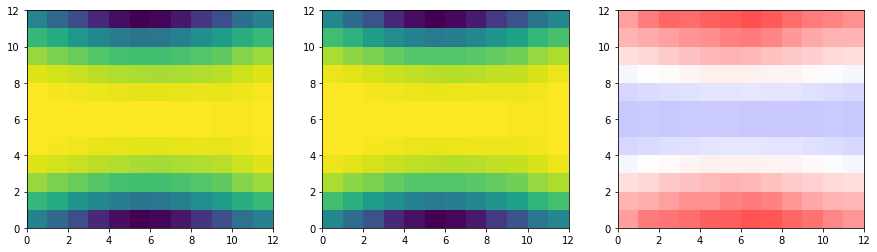

[output:4]

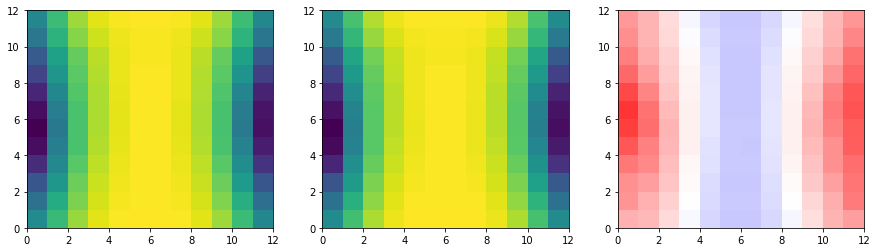

[output:3]

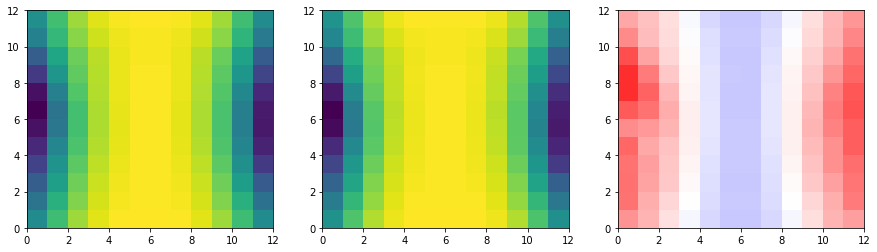

[output:5]

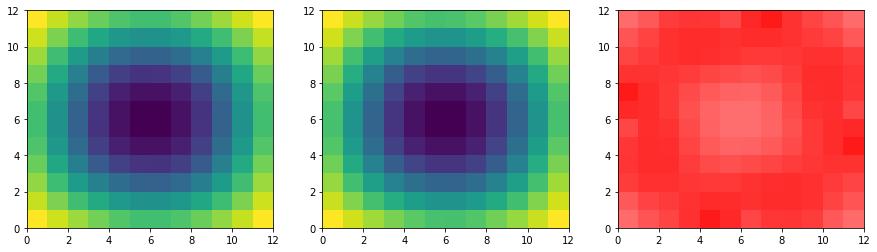

[output:0]

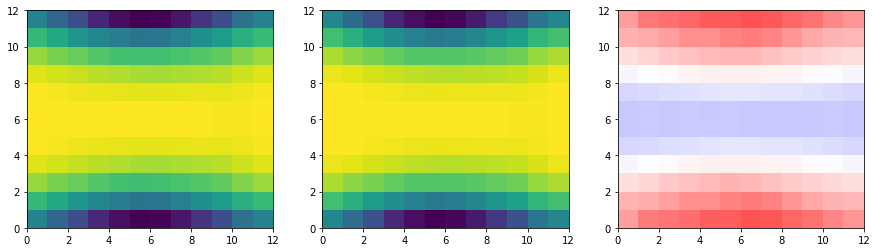

[output:2]

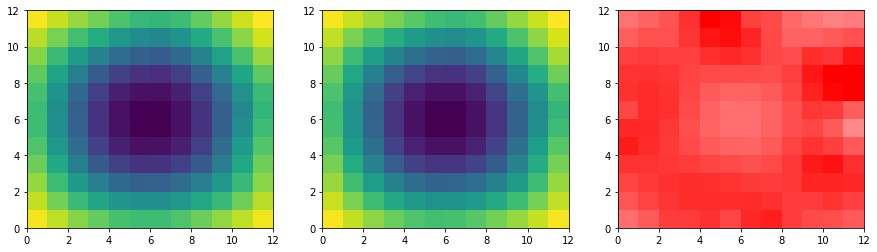

In [57]:
fig = plt.figure(figsize = (15, 4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.pcolormesh(pt_s[mpi_rank, 3:-3, 3:-3, -1].T)
ax2.pcolormesh(pt_f[mpi_rank, -1])
ax3.pcolormesh(pt_f[mpi_rank, -1]-pt_s[mpi_rank, 3:-3, 3:-3, -1].T, cmap="bwr", vmin=-3, vmax=3)


In [95]:
fortran_path = "/home/ajdas/pace/restart_data/v4.0/"
serial_path = "/home/ajdas/pace/test_data/8.1.1/c12_6ranks_standard_restart_15min/"


In [96]:
#data = Dataset(serial_path + "GFSPhysicsDriver-In.nc", "r")


In [97]:
#data

In [98]:
data = Dataset(serial_path + "GFSPhysicsDriver-In.nc", "r")
delp_s = np.array(data["delp"][0])
pt_s = np.array(data["pt"][0])
data.close()
delp_s = delp_s[:, 3:-3, 3:-3]
pt_s = pt_s[:, 3:-3, 3:-3]

delp_f = []
pt_f = []
for tile in range(1, 7, 1):
    for_data = Dataset(restart_path + "/fv_core.res.tile%s.nc" %tile, "r")
    delp_f.append(np.array(for_data["delp"][0]))
    pt_f.append(np.array(for_data["T"][0]))
    for_data.close()

delp_f = np.stack(delp_f)
delp_f = np.transpose(delp_f, (0, 3, 2, 1))
pt_f = np.stack(pt_f)
pt_f = np.transpose(pt_f, (0, 3, 2, 1))

if mpi_rank == 0:
    print(delp_s.shape, delp_f.shape)

[stdout:0] (6, 12, 12, 79) (6, 12, 12, 79)


In [99]:
if mpi_rank == 0:
    for lev in range(79):
        print("F delp min, max at lev %s: %.2f, %.2f" % (lev, np.nanmin(delp_f[:, :, :, lev]), np.nanmax(np.nanmax(delp_f[:, :, :, lev]))))
        print("S delp min, max at lev %s: %.2f, %.2f" % (lev, np.nanmin(delp_s[:, :, :, lev]), np.nanmax(np.nanmax(delp_s[:, :, :, lev]))))
        print("   max diff at lev %s: %.2e" % (lev, np.nanmax(np.abs(delp_f[:, :, :, lev] - delp_s[:, :, :, lev]))))

[stdout:0] F delp min, max at lev 0: 346.72, 346.72
S delp min, max at lev 0: 346.72, 346.72
   max diff at lev 0: 9.67e-10
F delp min, max at lev 1: 398.51, 398.51
S delp min, max at lev 1: 398.51, 398.51
   max diff at lev 1: 1.92e-09
F delp min, max at lev 2: 423.97, 423.97
S delp min, max at lev 2: 423.97, 423.97
   max diff at lev 2: 6.86e-11
F delp min, max at lev 3: 428.64, 428.64
S delp min, max at lev 3: 428.64, 428.64
   max diff at lev 3: 6.86e-11
F delp min, max at lev 4: 427.56, 427.56
S delp min, max at lev 4: 427.56, 427.56
   max diff at lev 4: 1.66e-10
F delp min, max at lev 5: 429.01, 429.01
S delp min, max at lev 5: 429.01, 429.01
   max diff at lev 5: 2.32e-10
F delp min, max at lev 6: 436.90, 436.90
S delp min, max at lev 6: 436.90, 436.90
   max diff at lev 6: 1.65e-10
F delp min, max at lev 7: 457.04, 457.04
S delp min, max at lev 7: 457.04, 457.04
   max diff at lev 7: 1.04e-10
F delp min, max at lev 8: 487.34, 487.34
S delp min, max at lev 8: 487.34, 487.34
   

[stdout:0] 1846.162970256315 1857.4190167008928


[output:0]

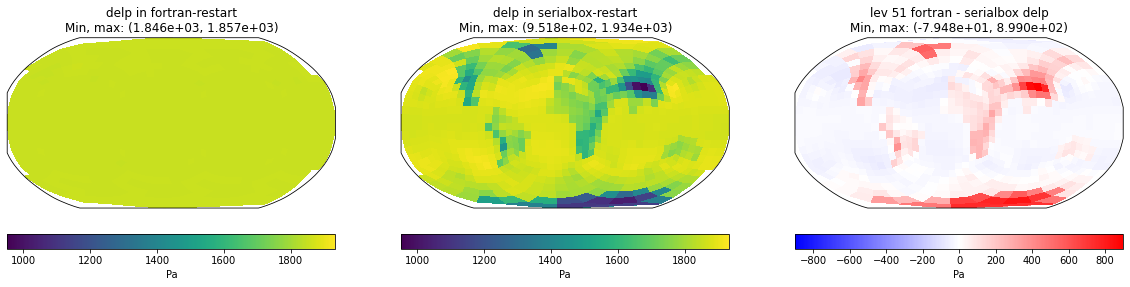

In [100]:
if mpi_rank == 0:
    var = "delp"
    lev = 51

    ffield = delp_f[:, :, :, lev]
    sfield = delp_s[:, :, :, lev]
    dfield = ffield - sfield
    print(ffield.min(), ffield.max())

    minvals = min(np.nanmin(ffield), np.nanmin(sfield))
    maxvals = max(np.nanmax(ffield), np.nanmax(sfield))
    dextrema = max(np.abs(np.nanmin(dfield)), np.abs(np.nanmax(dfield)))
    if minvals == maxvals:
        minvals -= .1
        maxvals += .1
        dextrema += .1

    fig = plt.figure(figsize = (20, 4))
    fig.patch.set_facecolor('white')
    gs = GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,.08])
    fvar = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
    svar = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
    dvar = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson())

    cax_f = fig.add_subplot(gs[1, 0])
    cax_s = fig.add_subplot(gs[1, 1])
    cax_d = fig.add_subplot(gs[1, 2])

    f1 = pcolormesh_cube(flat.data, flon.data, ffield, ax=fvar, vmin=minvals, vmax=maxvals)
    f2 = pcolormesh_cube(flat.data, flon.data, sfield, ax=svar, vmin=minvals, vmax=maxvals)
    f3 = pcolormesh_cube(flat.data, flon.data, dfield, ax=dvar, vmin=-dextrema, vmax=dextrema, cmap="bwr")

    plt.colorbar(f1, cax=cax_f, orientation="horizontal", label=fortran_vars[var].units)
    plt.colorbar(f2, cax=cax_s, orientation="horizontal", label=fortran_vars[var].units)
    plt.colorbar(f3, cax=cax_d, orientation="horizontal", label=fortran_vars[var].units)

    fvar.set_title("%s in fortran-restart\nMin, max: (%.3e, %.3e)" % (var, ffield.min(), ffield.max()))
    svar.set_title("%s in serialbox-restart\nMin, max: (%.3e, %.3e)" % (var, sfield.min(), sfield.max()))
    dvar.set_title("lev %s fortran - serialbox % s\nMin, max: (%.3e, %.3e)" % (lev, var, dfield.min(), dfield.max()))

    #plt.savefig(savedir + "FS_dycoreState_v0_%s.png" % var, dpi=200, bbox_inches='tight')

    plt.show()

[output:0]

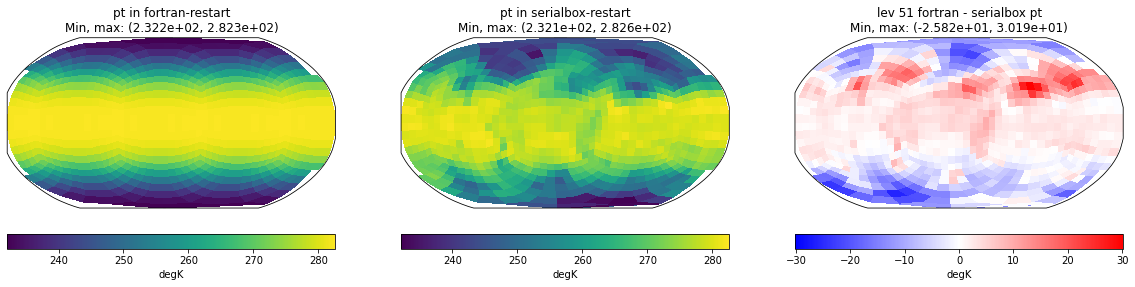

In [102]:
if mpi_rank == 0:
    var = "pt"
    lev = 51

    ffield = pt_f[:, :, :, lev]
    sfield = pt_s[:, :, :, lev]
    dfield = ffield - sfield

    minvals = min(np.nanmin(ffield), np.nanmin(sfield))
    maxvals = max(np.nanmax(ffield), np.nanmax(sfield))
    dextrema = max(np.abs(np.nanmin(dfield)), np.abs(np.nanmax(dfield)))
    if minvals == maxvals:
        minvals -= .1
        maxvals += .1
        dextrema += .1

    fig = plt.figure(figsize = (20, 4))
    fig.patch.set_facecolor('white')
    gs = GridSpec(2, 3, width_ratios=[1,1,1], height_ratios=[1,.08])
    fvar = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson())
    svar = fig.add_subplot(gs[0, 1], projection=ccrs.Robinson())
    dvar = fig.add_subplot(gs[0, 2], projection=ccrs.Robinson())

    cax_f = fig.add_subplot(gs[1, 0])
    cax_s = fig.add_subplot(gs[1, 1])
    cax_d = fig.add_subplot(gs[1, 2])

    f1 = pcolormesh_cube(flat.data, flon.data, ffield, ax=fvar, vmin=minvals, vmax=maxvals)
    f2 = pcolormesh_cube(flat.data, flon.data, sfield, ax=svar, vmin=minvals, vmax=maxvals)
    f3 = pcolormesh_cube(flat.data, flon.data, dfield, ax=dvar, vmin=-dextrema, vmax=dextrema, cmap="bwr")

    plt.colorbar(f1, cax=cax_f, orientation="horizontal", label=fortran_vars[var].units)
    plt.colorbar(f2, cax=cax_s, orientation="horizontal", label=fortran_vars[var].units)
    plt.colorbar(f3, cax=cax_d, orientation="horizontal", label=fortran_vars[var].units)

    fvar.set_title("%s in fortran-restart\nMin, max: (%.3e, %.3e)" % (var, ffield.min(), ffield.max()))
    svar.set_title("%s in serialbox-restart\nMin, max: (%.3e, %.3e)" % (var, sfield.min(), sfield.max()))
    dvar.set_title("lev %s fortran - serialbox % s\nMin, max: (%.3e, %.3e)" % (lev, var, dfield.min(), dfield.max()))

    #plt.savefig(savedir + "FS_dycoreState_v0_%s.png" % var, dpi=200, bbox_inches='tight')

    plt.show()